# 0. ETF Selection

We select the SPDR Gold Shares (GLD) ETF as the gold ETF. It is traded on Nasdaq, the currency is USD.

Similarly, we choose the Amundi CAC 40 UCITS ETF-C (C40.PA) as the equity ETF. It will track the CAC 40 index of France. It is traded on Paris Euronext, the currency is EUR.

The currency for Bitcoin is USD.

Data source: https://finance.yahoo.com/

# 1. Data Importing

In [1]:
import arch
import holidays
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import VECM
%matplotlib inline

In [2]:
gold_df = pd.read_csv("data/SPDR Gold Shares (GLD) Jan - Dec 2020.csv")
equity_df = pd.read_csv("data/Amundi CAC 40 UCITS ETF-C (C40.PA) Jan 2020 - Dec 2020.csv")
bitcoin_df = pd.read_csv('data/Bitcoin USD (BTC-USD) Jan 2020 - Dec 2020.csv')

Convert the data into the datetime format and make it the index to query the dataframe easier.

In [3]:
def convert_df(df):
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
    df.set_index("Date", inplace=True)   
    return df

gold_df = convert_df(gold_df)
equity_df = convert_df(equity_df)
bitcoin_df = convert_df(bitcoin_df)


We use the common subset of days for all 3 time series to make them comparable and to run the test for cointegration in question 7.

In [4]:
missing = set(equity_df.index) - set(gold_df.index)

In [5]:
def remove_missing_days(df, indices, missing):
    return df.loc[[index for index in indices if index not in missing]]

In [6]:
gold_df = remove_missing_days(gold_df, equity_df.index, missing)
equity_df = remove_missing_days(equity_df, equity_df.index, missing)
bitcoin_df = remove_missing_days(bitcoin_df, equity_df.index, missing)

In [7]:
assert equity_df.shape == gold_df.shape
assert equity_df.shape == bitcoin_df.shape

Verify that the time range is correct.

In [8]:
gold_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,143.860001,144.210007,143.399994,143.949997,143.949997,7733800
2020-01-03,145.750000,146.320007,145.399994,145.860001,145.860001,12272800
2020-01-06,148.440002,148.479996,146.949997,147.389999,147.389999,14403300
2020-01-07,147.570007,148.139999,147.429993,147.970001,147.970001,7978500
2020-01-08,148.490005,148.610001,146.139999,146.860001,146.860001,22248500


In [9]:
gold_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-23,175.100006,176.210007,175.059998,175.649994,175.649994,6542800
2020-12-24,175.550003,176.369995,175.509995,176.350006,176.350006,3695400
2020-12-28,177.259995,177.910004,175.630005,175.710007,175.710007,7778700
2020-12-29,176.250000,176.970001,175.570007,176.350006,176.350006,5983700
2020-12-30,176.440002,177.720001,176.440002,177.699997,177.699997,5914000


In [10]:
equity_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,88.589996,89.239998,88.589996,89.239998,89.239998,124.0
2020-01-03,88.489998,88.889999,88.309998,88.769997,88.769997,0.0
2020-01-06,88.529999,88.599998,87.750000,88.559998,88.559998,563.0
2020-01-07,88.839996,89.260002,88.500000,88.500000,88.500000,0.0
2020-01-08,88.120003,89.300003,88.120003,89.139999,89.139999,212.0


In [11]:
equity_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-23,82.480003,83.330002,82.000000,83.250000,83.250000,68117.0
2020-12-24,83.419998,83.550003,82.930000,83.139999,83.139999,32892.0
2020-12-28,83.849998,84.290001,83.410004,84.160004,84.160004,20640.0
2020-12-29,84.440002,84.680000,84.320000,84.449997,84.449997,20668.0
2020-12-30,84.489998,84.699997,84.300003,84.339996,84.339996,3829.0


In [12]:
bitcoin_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481031
2020-01-06,7410.452148,7781.867188,7409.292969,7769.219238,7769.219238,23276261598
2020-01-07,7768.682129,8178.215820,7768.227539,8163.692383,8163.692383,28767291326
2020-01-08,8161.935547,8396.738281,7956.774414,8079.862793,8079.862793,31672559264


In [13]:
bitcoin_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-23,23781.974609,24024.490234,22802.646484,23241.345703,23241.345703,51146161904
2020-12-24,23240.203125,23768.337891,22777.597656,23735.949219,23735.949219,41080759712
2020-12-28,26280.822266,27389.111328,26207.640625,27084.808594,27084.808594,49056742892
2020-12-29,27081.810547,27370.720703,25987.298828,27362.437500,27362.437500,45265946774
2020-12-30,27360.089844,28937.740234,27360.089844,28840.953125,28840.953125,51287442703


# 2. Data Processing

We use adjusted close prices to calculate the daily returns. Adjusted close prices are the prices that already take into account stock split and dividends, which reflex more accurate the change of the prices.

In [14]:
equity_df["Daily Return"] = equity_df["Adj Close"].pct_change(1)
equity_df.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2020-01-02,88.589996,89.239998,88.589996,89.239998,89.239998,124.0,NaN
2020-01-03,88.489998,88.889999,88.309998,88.769997,88.769997,0.0,-0.005267
2020-01-06,88.529999,88.599998,87.750000,88.559998,88.559998,563.0,-0.002366
2020-01-07,88.839996,89.260002,88.500000,88.500000,88.500000,0.0,-0.000677
2020-01-08,88.120003,89.300003,88.120003,89.139999,89.139999,212.0,0.007232


In [15]:
gold_df["Daily Return"] = gold_df["Adj Close"].pct_change(1)
gold_df.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2020-01-02,143.860001,144.210007,143.399994,143.949997,143.949997,7733800,NaN
2020-01-03,145.750000,146.320007,145.399994,145.860001,145.860001,12272800,0.013269
2020-01-06,148.440002,148.479996,146.949997,147.389999,147.389999,14403300,0.010489
2020-01-07,147.570007,148.139999,147.429993,147.970001,147.970001,7978500,0.003935
2020-01-08,148.490005,148.610001,146.139999,146.860001,146.860001,22248500,-0.007502


In [16]:
bitcoin_df["Daily Return"] = bitcoin_df["Adj Close"].pct_change(1)
bitcoin_df.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465,NaN
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481031,0.051452
2020-01-06,7410.452148,7781.867188,7409.292969,7769.219238,7769.219238,23276261598,0.057773
2020-01-07,7768.682129,8178.215820,7768.227539,8163.692383,8163.692383,28767291326,0.050774
2020-01-08,8161.935547,8396.738281,7956.774414,8079.862793,8079.862793,31672559264,-0.010269


# 3. Data Summaries

In [17]:
# Helper
df_names = {0: "gold ETF", 1: "equity ETF", 2: "Bitcoin"}
dfs = [gold_df, equity_df, bitcoin_df]
def get_data(df, month_start, month_end, column=None):
    data = df[(df.index >= f"2020-{month_start:02d}-01") & (df.index < f"2020-{month_end:02d}-01")]
    if column: 
        data = data[column]
    return data

In [18]:
def summarize_data(df):
    data = get_data(df, 3, 12, "Adj Close")
    moving_avg = data.rolling(20, min_periods=1).mean()
    return get_data(moving_avg, 4, 12)


We can check that the data is null for several days of the equity time series. For that reason, for the windows that have a null value, we'll take the average of the rest as an approximate.

In [19]:
equity_df.isna().sum()

Open            3
High            3
Low             3
Close           3
Adj Close       3
Volume          3
Daily Return    1
dtype: int64

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Moving average for gold ETF from April to December


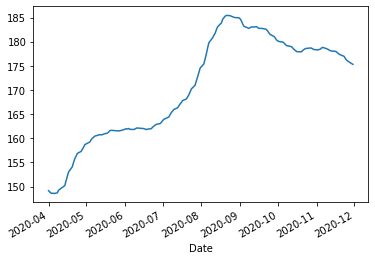

Date
2020-04-01    149.164499
2020-04-02    148.884998
2020-04-03    148.639998
2020-04-06    148.593498
2020-04-07    148.671498
Name: Adj Close, dtype: float64
Date
2020-11-23    176.975001
2020-11-24    176.503500
2020-11-25    176.172500
2020-11-27    175.792000
2020-11-30    175.315500
Name: Adj Close, dtype: float64
------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Moving average for equity ETF from April to December


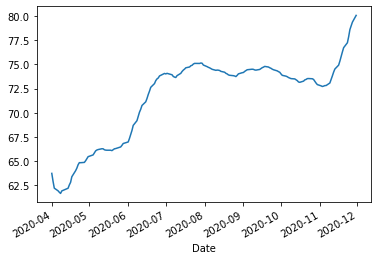

Date
2020-04-01    63.739499
2020-04-02    62.921499
2020-04-03    62.211000
2020-04-06    61.938000
2020-04-07    61.789000
Name: Adj Close, dtype: float64
Date
2020-11-23    77.2455
2020-11-24    77.8610
2020-11-25    78.6065
2020-11-27    79.3740
2020-11-30    80.0760
Name: Adj Close, dtype: float64
------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Moving average for Bitcoin from April to December


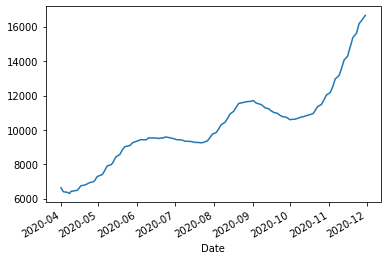

Date
2020-04-01    6642.140503
2020-04-02    6527.883594
2020-04-03    6408.425659
2020-04-06    6375.832495
2020-04-07    6339.166748
Name: Adj Close, dtype: float64
Date
2020-11-23    15628.844727
2020-11-24    15901.507031
2020-11-25    16174.548828
2020-11-27    16358.074805
2020-11-30    16662.040479
Name: Adj Close, dtype: float64


In [20]:
moving_avgs = []
for index, df in enumerate(dfs):
    print("-" * 78)
    print("-" * 78)
    print("-" * 78)
    print(f"Moving average for {df_names[index]} from April to December")
    data = summarize_data(df)
    data.plot()
    plt.show()
    print(data.head())
    print(data.tail())
    moving_avgs.append(data)

# 4. Graphing

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
The prices and its moving averages for gold ETF from April to December


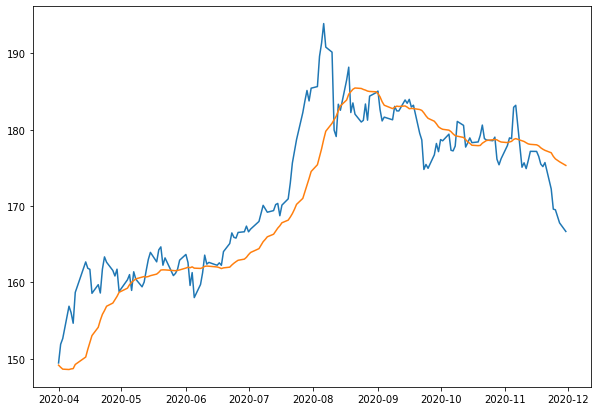

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
The prices and its moving averages for equity ETF from April to December


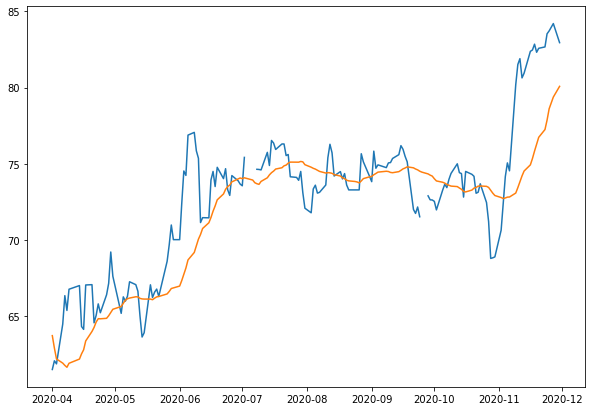

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
The prices and its moving averages for Bitcoin from April to December


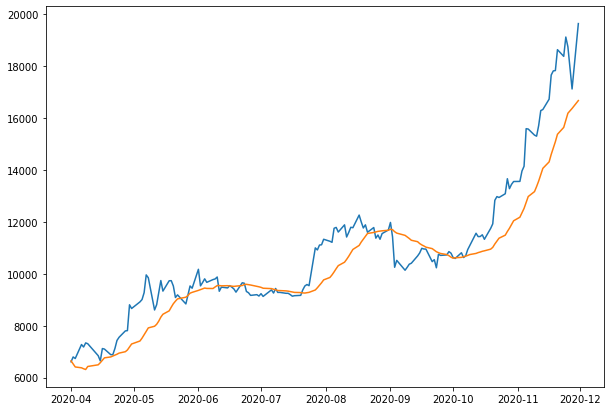

In [21]:
for index, df in enumerate(dfs):
    print("-" * 78)
    print("-" * 78)
    print("-" * 78)
    print(f"The prices and its moving averages for {df_names[index]} from April to December")
    data = get_data(df, 4, 12, "Adj Close")
    moving_avg = moving_avgs[index]
    plt.figure(figsize=(10,7))
    plt.plot(data)
    plt.plot(moving_avg)
    plt.show()

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
The prices of gold ETF and equity ETF from April to December


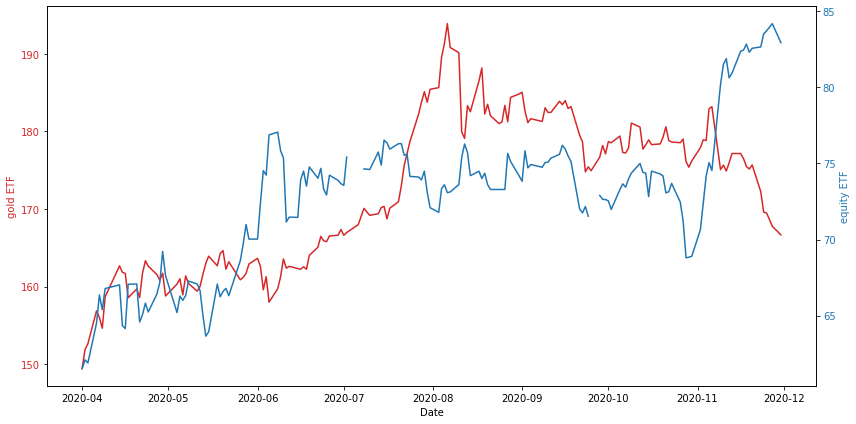

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
The prices of gold ETF and Bitcoin from April to December


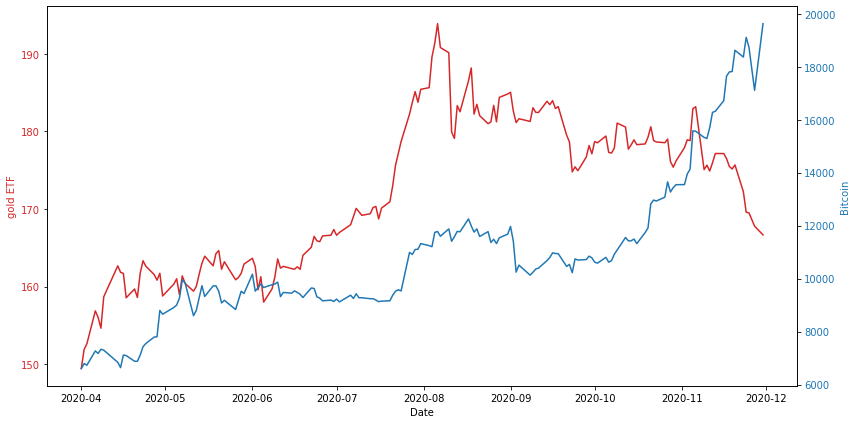

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
The prices of equity ETF and Bitcoin from April to December


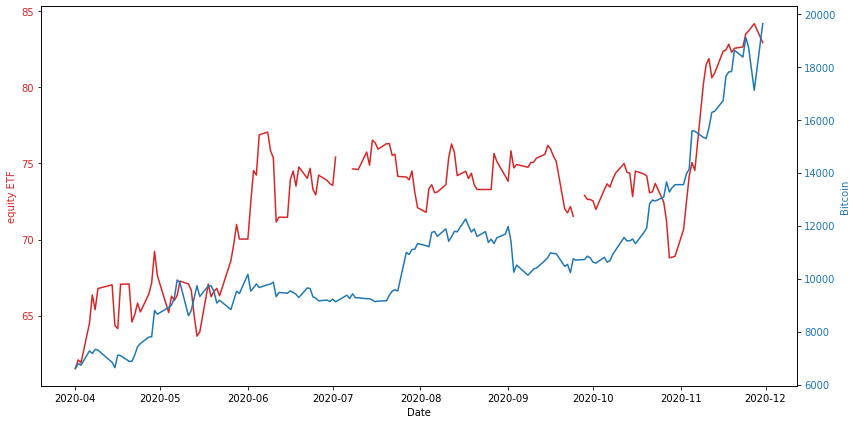

In [22]:
for i, j in [(0, 1), (0, 2), (1, 2)]:
    print("-" * 78)
    print("-" * 78)
    print("-" * 78)
    print(f"The prices of {df_names[i]} and {df_names[j]} from April to December")
    y1_data = get_data(dfs[i], 4, 12, "Adj Close")
    y2_data = get_data(dfs[j], 4, 12, "Adj Close")
    fig, y1_axis = plt.subplots(figsize=(12,6))

    y1_color = 'tab:red'
    y2_color = 'tab:blue'

    y1_axis.set_xlabel('Date')
    y1_axis.set_ylabel(df_names[i], color=y1_color)
    y1_axis.plot( y1_data, color=y1_color)
    y1_axis.tick_params(axis='y', labelcolor=y1_color)
    y2_axis = y1_axis.twinx() 


    y2_axis.set_ylabel(df_names[j], color=y2_color)  
    y2_axis.plot( y2_data, color=y2_color)
    y2_axis.tick_params(axis='y', labelcolor=y2_color)

    fig.tight_layout()  
    plt.show()

# 5. Fitting a GARCH model

In [23]:
def get_data(df, month_start, month_end, column):
    return df[(df.index >= f"2020-{month_start:02d}-01") & (df.index < f"2020-{month_end:02d}-01")][column]

In [24]:
def fit_garch(data, garch_type="GARCH"):
    if garch_type == "TARCH":
        garch = arch.arch_model(data, vol='GARCH', p=1, o=1, q=1, power=1)
    else:
        garch = arch.arch_model(data, vol=garch_type, p=1, o=0, q=1)
    garch_fitted = garch.fit()
    print(garch_fitted.summary())
    if garch_type != "FIGARCH":
        omega = garch_fitted.params["omega"]
        alpha = garch_fitted.params["alpha[1]"]
        beta = garch_fitted.params["beta[1]"]
        print(f"Unconditional variance: {omega/(1 - alpha - beta)}")


In [25]:
for model in ["GARCH", "EGARCH", "FIGARCH", "TARCH"]:
    index = 1
    df = dfs[index]
    print("-" * 78)
    print("-" * 78)
    print("-" * 78)
    print(f"{model} model for {df_names[index]} from April to December")
    data = get_data(df, 4, 12, "Daily Return")
    data = data.dropna()
    fit_garch(data, model)

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
GARCH model for equity ETF from April to December
Iteration:      1,   Func. Count:      6,   Neg. LLF: 10482042.946478657
Iteration:      2,   Func. Count:     17,   Neg. LLF: 148093369858.76276
Iteration:      3,   Func. Count:     26,   Neg. LLF: 496268828493157.7
Iteration:      4,   Func. Count:     36,   Neg. LLF: -443.3262037603009
Optimization terminated successfully    (Exit mode 0)
            Current function value: -443.32620406205956
            Iterations: 8
            Function evaluations: 36
            Gradient evaluations: 4
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           Daily Return   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:

C:\Users\trinh\AppData\Roaming\Python\Python38\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002994. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\trinh\AppData\Roaming\Python\Python38\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002994. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\trinh\AppData\Roaming\Python\Py

# 6. Assessing stationarity

Use Augmented Dickey-Fuller test with regression = "c" to test for stationary

In [26]:
for index, df in enumerate(dfs):
    print("-" * 78)
    print("-" * 78)
    print("-" * 78)
    print(f"Test stationary for {df_names[index]} from April to December")
    X = get_data(df, 4, 12, "Daily Return").values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Test stationary for gold ETF from April to December
ADF Statistic: -12.807794
p-value: 0.000000
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576
------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Test stationary for equity ETF from April to December
ADF Statistic: -12.472203
p-value: 0.000000
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576
------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------

For all there time series, we can reject the null hypothesis that there is a unit root in the time series and the time series are stationary.

# 7. Modelling Cointegration

In [27]:
data1 = get_data(gold_df, 4, 6, "Daily Return").values
data2 = get_data(equity_df, 4, 6, "Daily Return").values
data3 = get_data(bitcoin_df, 4, 6, "Daily Return").values

In [28]:
coint(data1, np.array([data2, data3]).T)

(-6.076460637243138,
 5.692753720973776e-06,
 array([-4.69574274, -3.97301265, -3.618289  ]))

In [29]:
coint(data2, np.array([data1, data3]).T)

(-6.203463603398757,
 2.972096825666223e-06,
 array([-4.69574274, -3.97301265, -3.618289  ]))

In [30]:
coint(data3, np.array([data1, data2]).T)

(-5.93178147713331,
 1.1733043376457846e-05,
 array([-4.69574274, -3.97301265, -3.618289  ]))

p-value < 0.01 for all tests, we conclude that there are cointegrating vectors.

Vector Error Correction Model

In [31]:
data = np.array([data1, data2, data3]).T
model = VECM(data, coint_rank=1)
vecm_res = model.fit()
vecm_res.gamma.round(4)
vecm_res.summary()
forecast, lower, upper = vecm_res.predict(5, 0.05)
print("lower bounds of confidence intervals:")
print(lower.round(3))
print("\npoint forecasts:")
print(forecast.round(3))
print("\nupper bounds of confidence intervals:")
print(upper.round(3))

lower bounds of confidence intervals:
[[-0.018 -0.046 -0.086]
 [-0.024 -0.046 -0.122]
 [-0.03  -0.053 -0.142]
 [-0.034 -0.058 -0.158]
 [-0.038 -0.061 -0.172]]

point forecasts:
[[ 0.01  -0.004  0.021]
 [ 0.008  0.     0.002]
 [ 0.008 -0.001  0.007]
 [ 0.008 -0.003  0.007]
 [ 0.008 -0.002  0.008]]

upper bounds of confidence intervals:
[[0.037 0.039 0.128]
 [0.039 0.046 0.126]
 [0.046 0.051 0.155]
 [0.05  0.052 0.171]
 [0.054 0.056 0.189]]


In [32]:
data1 = get_data(gold_df, 7, 9, "Daily Return").values
data2 = get_data(equity_df, 7, 9, "Daily Return").values
data3 = get_data(bitcoin_df, 7, 9, "Daily Return").values

In [33]:
coint(data1, np.array([data2, data3]).T)

(-6.922723638048469,
 5.848143640071725e-08,
 array([-4.6556178 , -3.95031996, -3.60224723]))

In [34]:
coint(data2, np.array([data1, data3]).T)

(-3.7317779390504793,
 0.05119188151529683,
 array([-4.6556178 , -3.95031996, -3.60224723]))

In [35]:
coint(data3, np.array([data1, data2]).T)

(-8.835667550986745,
 3.3294143920743777e-13,
 array([-4.6556178 , -3.95031996, -3.60224723]))

Interestingly, we can't reject the null hypothesis for the test for the equity ETF and the combintion of gold and bitcoin ETF. We can reject the null hypothesis for the other two tests.

In [36]:
data = np.array([data1, data2, data3]).T
model = VECM(data, coint_rank=1)
vecm_res = model.fit()
vecm_res.gamma.round(4)
vecm_res.summary()
forecast, lower, upper = vecm_res.predict(5, 0.05)
print("lower bounds of confidence intervals:")
print(lower.round(3))
print("\npoint forecasts:")
print(forecast.round(3))
print("\nupper bounds of confidence intervals:")
print(upper.round(3))

lower bounds of confidence intervals:
[[-0.022 -0.023 -0.05 ]
 [-0.03  -0.024 -0.065]
 [-0.035 -0.027 -0.074]
 [-0.041 -0.028 -0.085]
 [-0.045 -0.029 -0.092]]

point forecasts:
[[ 0.01  -0.001  0.018]
 [ 0.005 -0.001  0.007]
 [ 0.008 -0.002  0.015]
 [ 0.007 -0.002  0.01 ]
 [ 0.007 -0.002  0.014]]

upper bounds of confidence intervals:
[[0.042 0.022 0.085]
 [0.041 0.023 0.079]
 [0.051 0.023 0.105]
 [0.054 0.024 0.106]
 [0.059 0.025 0.119]]
